# Synchronized Dual-Output Square Wave Generator
---

## Objective
Generate two perfectly synchronized digital output signals:
- **Output 1 (DAC0)**: 10 MHz square wave, gated ON/OFF at 200 kHz (burst pattern)
- **Output 2 (DAC1)**: 200 kHz square wave, synchronized with Output 1's gating

## Synchronization Approach
Since we need sample-level synchronization between DAC outputs:

### Option A: Same Tile, Different Channels (Best for Sync)
- If both DACs are on the **same tile**, they share the same clock and sample exactly together
- No MTS needed - inherently synchronized at the sample level

### Option B: Different Tiles with MTS
- If DACs are on **different tiles**, we need Multi-Tile Synchronization (MTS)
- MTS aligns the internal FIFOs and clock phases across tiles
- RFSoC4x2: DAC_A is Tile 2, DAC_B is Tile 0 - they're on different tiles!

### Current Approach (using SeparateDacOverlay)
The `SeparateDacOverlay` loads both BRAMs and starts both DACs from a **single trigger**,
ensuring they start at the exact same moment. The key is:
1. Both waveforms computed from the same time axis
2. Both BRAMs loaded before start
3. Single `start_dacs()` call starts both simultaneously

---

In [6]:
'''
Synchronized Dual-Output Waveform Generator
- Output 1: 10 MHz pattern, gated at 200 kHz
- Output 2: 200 kHz square wave (gate signal)
'''

import numpy as np
from scipy.signal import square
import matplotlib.pyplot as plt
import os

# ============================================================
# MOCK OVERLAY FOR LOCAL TESTING
# ============================================================
class MockOverlay:
    """Simulates PYNQ overlay for local development without hardware"""
    def __init__(self, bitfile):
        print(f"[MOCK MODE] Initialized with bitfile: {bitfile}")
        print("[MOCK MODE] No hardware present - simulating BRAM interface")
        # Simulate BRAM buffers (typical size: 16384 samples)
        self.dac0_bram = np.zeros(16384, dtype=np.int16)
        self.dac1_bram = np.zeros(16384, dtype=np.int16)
    
    def start_dacs(self):
        """Simulate DAC start - just print what would happen"""
        print("\n[MOCK] DACs started (no actual hardware output)")
        print(f"[MOCK] DAC0 BRAM: {len(self.dac0_bram)} samples, range [{self.dac0_bram.min()}, {self.dac0_bram.max()}]")
        print(f"[MOCK] DAC1 BRAM: {len(self.dac1_bram)} samples, range [{self.dac1_bram.min()}, {self.dac1_bram.max()}]")
        nonzero_0 = np.count_nonzero(self.dac0_bram)
        nonzero_1 = np.count_nonzero(self.dac1_bram)
        print(f"[MOCK] DAC0 non-zero samples: {nonzero_0} ({nonzero_0/len(self.dac0_bram)*100:.1f}%)")
        print(f"[MOCK] DAC1 non-zero samples: {nonzero_1} ({nonzero_1/len(self.dac1_bram)*100:.1f}%)")

# ============================================================
# AUTO-DETECT HARDWARE vs MOCK MODE
# ============================================================
BITFILE = "overlays/base_wrapper.bit"

try:
    from pynq import Overlay
    ol = Overlay(BITFILE)
    print("✓ Real PYNQ Overlay loaded - running on RFSoC hardware")
except Exception as e:
    print(f"⚠ Could not load PYNQ Overlay: {e}")
    print("→ Switching to MOCK MODE for local testing")
    ol = MockOverlay(BITFILE)


⚠ Could not load PYNQ Overlay: No Devices Found
→ Switching to MOCK MODE for local testing
[MOCK MODE] Initialized with bitfile: overlays/base_wrapper.bit
[MOCK MODE] No hardware present - simulating BRAM interface


In [7]:
# ============================================================
# SYSTEM PARAMETERS
# ============================================================
DAC_SR = 4.0e9          # Sample rate: 4 GS/s
N = ol.dac0_bram.shape[0]  # Buffer length (samples)

# Target Frequencies
F_CARRIER = 10.0e6      # 10 MHz carrier/pattern frequency
F_GATE = 200.0e3        # 200 kHz gating frequency

# Output amplitude for digital signals (driving transistor)
# Using full range: 0 = LOW, 32767 = HIGH (int16 max positive)
DAC_HIGH = 2**15 - 1    # Maximum positive value (32767)
DAC_LOW = 0             # Zero/off

# Print configuration
print(f"DAC Sample Rate: {DAC_SR/1e9:.1f} GS/s")
print(f"Buffer Length: {N} samples")
print(f"Buffer Duration: {N/DAC_SR*1e6:.2f} µs")
print(f"Carrier Frequency: {F_CARRIER/1e6:.2f} MHz")
print(f"Gate Frequency: {F_GATE/1e3:.1f} kHz")

DAC Sample Rate: 4.0 GS/s
Buffer Length: 16384 samples
Buffer Duration: 4.10 µs
Carrier Frequency: 10.00 MHz
Gate Frequency: 200.0 kHz


In [8]:
# ============================================================
# FREQUENCY ADJUSTMENT FOR PERFECT CYCLES
# ============================================================
# To prevent clicks/glitches when the buffer loops, we need
# an integer number of cycles in the buffer.

def adjust_frequency(target_freq, num_samples, sample_rate):
    """
    Adjust frequency to fit exact integer cycles in the buffer.
    
    Args:
        target_freq: Desired frequency in Hz
        num_samples: Number of samples in buffer
        sample_rate: Sample rate in Hz
    
    Returns:
        Adjusted frequency that fits exactly
    """
    # Calculate cycles that would fit
    num_cycles = round((target_freq * num_samples) / sample_rate)
    # Recalculate exact frequency
    actual_freq = (num_cycles * sample_rate) / num_samples
    return actual_freq, num_cycles

# Adjust both frequencies
F_CARRIER_ACTUAL, carrier_cycles = adjust_frequency(F_CARRIER, N, DAC_SR)
F_GATE_ACTUAL, gate_cycles = adjust_frequency(F_GATE, N, DAC_SR)

print(f"\nFrequency Adjustment for Perfect Buffer Looping:")
print(f"  Carrier: {F_CARRIER/1e6:.4f} MHz → {F_CARRIER_ACTUAL/1e6:.6f} MHz ({carrier_cycles} cycles)")
print(f"  Gate: {F_GATE/1e3:.4f} kHz → {F_GATE_ACTUAL/1e3:.6f} kHz ({gate_cycles} cycles)")


Frequency Adjustment for Perfect Buffer Looping:
  Carrier: 10.0000 MHz → 10.009766 MHz (41 cycles)
  Gate: 200.0000 kHz → 244.140625 kHz (1 cycles)


In [9]:
# ============================================================
# WAVEFORM GENERATION
# ============================================================
# IMPORTANT: Both waveforms use the SAME time axis to ensure synchronization!

t = np.arange(N) / DAC_SR  # Shared time axis

# -----------------------------
# OUTPUT 2 (DAC1): 200 kHz Gate Signal
# -----------------------------
# This is a simple square wave at 200 kHz
# Values: 0 (LOW) when negative, 1 (HIGH) when positive
gate_signal_raw = square(2 * np.pi * F_GATE_ACTUAL * t)
# Convert to binary: -1,1 → 0,1
gate_binary = (gate_signal_raw > 0).astype(np.float64)

# Scale to DAC output levels
wave_gate = gate_binary * DAC_HIGH

# -----------------------------
# OUTPUT 1 (DAC0): 10 MHz Carrier, Gated by 200 kHz
# -----------------------------
# 10 MHz square wave
carrier_raw = square(2 * np.pi * F_CARRIER_ACTUAL * t)
# Convert to binary: -1,1 → 0,1
carrier_binary = (carrier_raw > 0).astype(np.float64)

# Gate the carrier: only output when gate is HIGH
# This creates bursts of 10 MHz every time the 200 kHz gate is HIGH
wave_gated_carrier = carrier_binary * gate_binary * DAC_HIGH

print(f"Waveforms generated:")
print(f"  Output 1 (DAC0): 10 MHz carrier, gated at 200 kHz")
print(f"  Output 2 (DAC1): 200 kHz square wave (gate signal)")

Waveforms generated:
  Output 1 (DAC0): 10 MHz carrier, gated at 200 kHz
  Output 2 (DAC1): 200 kHz square wave (gate signal)


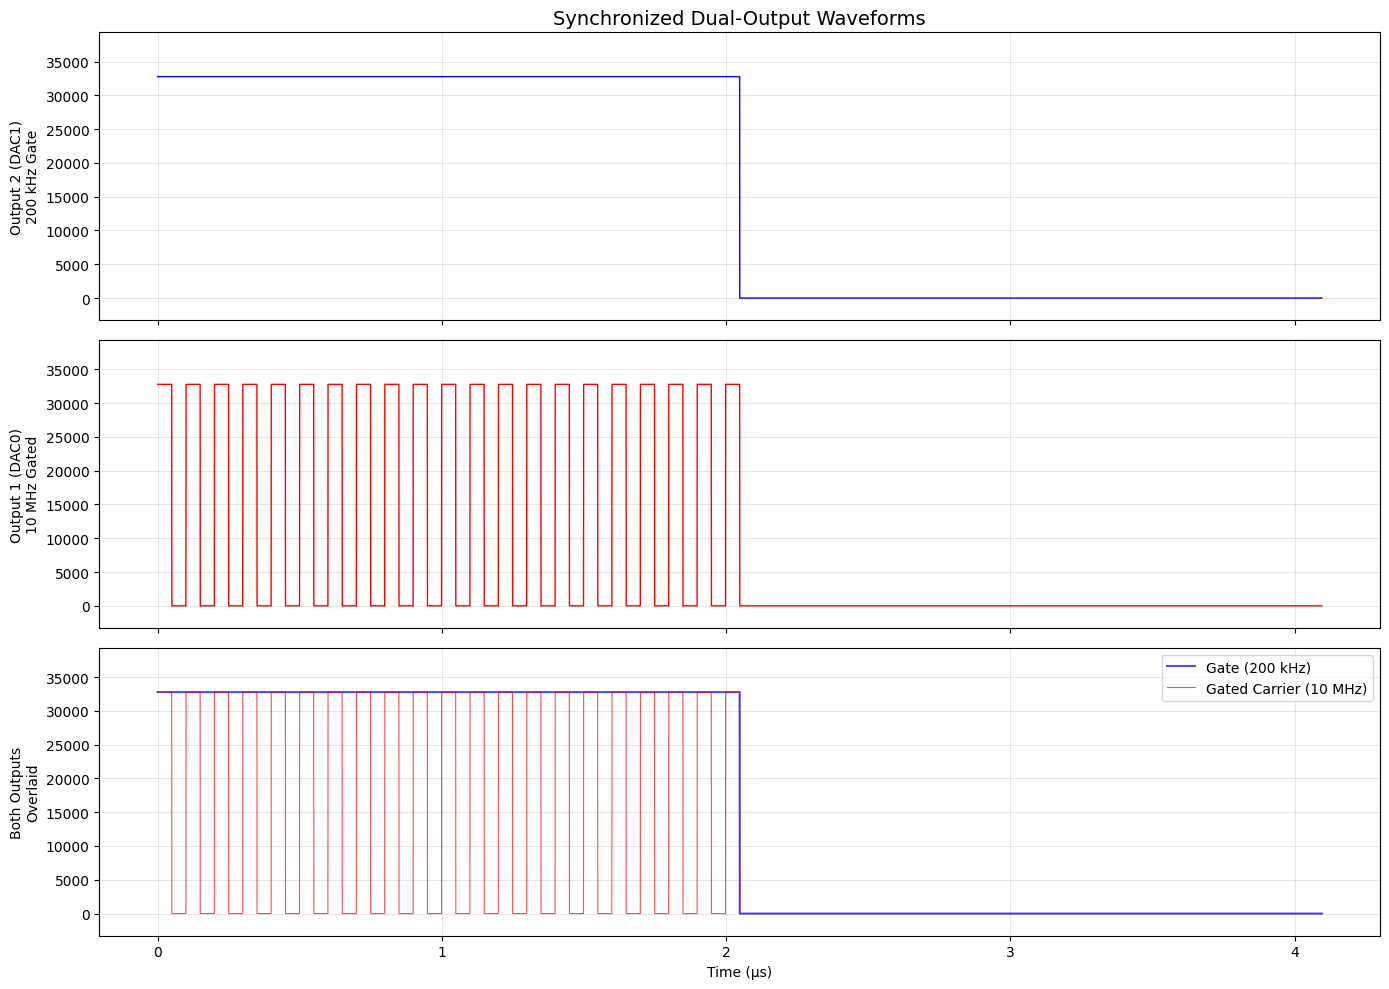


Plot shows 16384 samples (4.10 µs)


In [10]:
# ============================================================
# VISUALIZE THE WAVEFORMS
# ============================================================
# Plot a few cycles to verify synchronization

# Calculate samples to show ~2-3 gate cycles
gate_period_samples = int(DAC_SR / F_GATE_ACTUAL)
plot_samples = min(gate_period_samples * 3, N)  # Show 3 gate cycles

fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

# Time in microseconds for plotting
t_us = t[:plot_samples] * 1e6

# Plot Gate Signal (Output 2)
axes[0].plot(t_us, wave_gate[:plot_samples], 'b-', linewidth=1)
axes[0].set_ylabel('Output 2 (DAC1)\n200 kHz Gate', fontsize=10)
axes[0].set_ylim([-DAC_HIGH*0.1, DAC_HIGH*1.2])
axes[0].grid(True, alpha=0.3)
axes[0].set_title('Synchronized Dual-Output Waveforms', fontsize=14)

# Plot Gated Carrier (Output 1)
axes[1].plot(t_us, wave_gated_carrier[:plot_samples], 'r-', linewidth=1)
axes[1].set_ylabel('Output 1 (DAC0)\n10 MHz Gated', fontsize=10)
axes[1].set_ylim([-DAC_HIGH*0.1, DAC_HIGH*1.2])
axes[1].grid(True, alpha=0.3)

# Plot Both Overlaid
axes[2].plot(t_us, wave_gate[:plot_samples], 'b-', linewidth=1.5, alpha=0.7, label='Gate (200 kHz)')
axes[2].plot(t_us, wave_gated_carrier[:plot_samples], 'r-', linewidth=0.8, alpha=0.7, label='Gated Carrier (10 MHz)')
axes[2].set_ylabel('Both Outputs\nOverlaid', fontsize=10)
axes[2].set_xlabel('Time (µs)', fontsize=10)
axes[2].set_ylim([-DAC_HIGH*0.1, DAC_HIGH*1.2])
axes[2].grid(True, alpha=0.3)
axes[2].legend(loc='upper right')

plt.tight_layout()
plt.show()

print(f"\nPlot shows {plot_samples} samples ({plot_samples/DAC_SR*1e6:.2f} µs)")

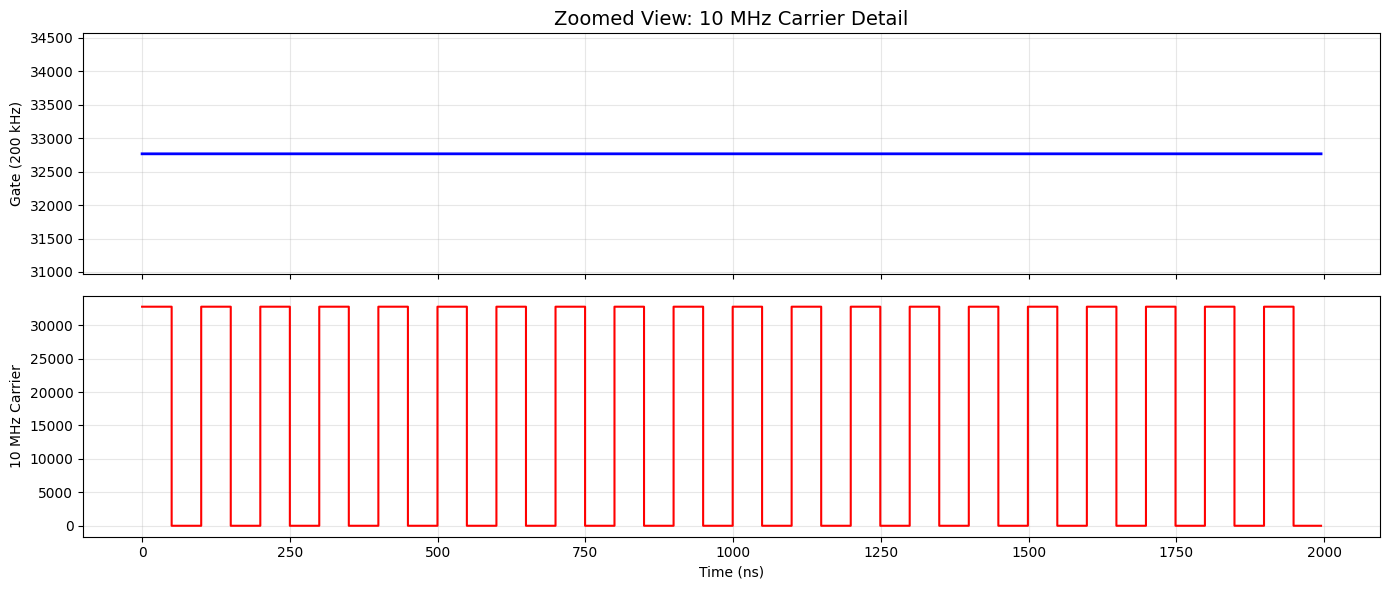

Carrier period: 99.90 ns (399 samples)


In [11]:
# ============================================================
# ZOOM IN TO VERIFY 10 MHz CARRIER
# ============================================================
# Show detail of the carrier frequency

# Calculate samples to show ~10 carrier cycles
carrier_period_samples = int(DAC_SR / F_CARRIER_ACTUAL)
zoom_samples = carrier_period_samples * 20  # Show 20 carrier cycles

# Find a region where gate is HIGH
start_idx = 0
for i in range(len(gate_binary) - zoom_samples):
    if gate_binary[i] > 0.5:  # Gate is HIGH
        start_idx = i
        break

end_idx = start_idx + zoom_samples
t_zoom_ns = t[start_idx:end_idx] * 1e9  # Time in nanoseconds

fig, axes = plt.subplots(2, 1, figsize=(14, 6), sharex=True)

# Plot Gate (should be constant HIGH in this region)
axes[0].plot(t_zoom_ns, wave_gate[start_idx:end_idx], 'b-', linewidth=2)
axes[0].set_ylabel('Gate (200 kHz)', fontsize=10)
axes[0].grid(True, alpha=0.3)
axes[0].set_title('Zoomed View: 10 MHz Carrier Detail', fontsize=14)

# Plot Carrier with digital-style
axes[1].step(t_zoom_ns, wave_gated_carrier[start_idx:end_idx], 'r-', linewidth=1.5, where='post')
axes[1].set_ylabel('10 MHz Carrier', fontsize=10)
axes[1].set_xlabel('Time (ns)', fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Carrier period: {1e9/F_CARRIER_ACTUAL:.2f} ns ({carrier_period_samples} samples)")

In [12]:
# ============================================================
# LOAD AND START DACs
# ============================================================

# Convert to int16 for the DAC
wave_out1_i16 = wave_gated_carrier.astype(np.int16)  # DAC0: Gated 10 MHz
wave_out2_i16 = wave_gate.astype(np.int16)          # DAC1: 200 kHz gate

# Verify the waveform is binary (only 0 or DAC_HIGH)
unique_vals_1 = np.unique(wave_out1_i16)
unique_vals_2 = np.unique(wave_out2_i16)
print(f"Output 1 unique values: {unique_vals_1}")
print(f"Output 2 unique values: {unique_vals_2}")

# CRITICAL: Load BOTH BRAMs BEFORE starting
# This ensures they start from the same point
ol.dac0_bram[:] = wave_out1_i16  # Output 1: Gated 10 MHz carrier
ol.dac1_bram[:] = wave_out2_i16  # Output 2: 200 kHz gate signal
print("\nWaveforms loaded to both DAC BRAMs.")

# Start both DACs simultaneously
# This single call ensures both start at the exact same moment
ol.start_dacs()
print("DACs started - outputting synchronized waveforms!")

Output 1 unique values: [    0 32767]
Output 2 unique values: [    0 32767]

Waveforms loaded to both DAC BRAMs.

[MOCK] DACs started (no actual hardware output)
[MOCK] DAC0 BRAM: 16384 samples, range [0, 32767]
[MOCK] DAC1 BRAM: 16384 samples, range [0, 32767]
[MOCK] DAC0 non-zero samples: 4196 (25.6%)
[MOCK] DAC1 non-zero samples: 8192 (50.0%)
DACs started - outputting synchronized waveforms!


In [13]:
# ============================================================
# STOP OUTPUT (Set to Zero)
# ============================================================

ol.dac0_bram[:] = np.zeros(N, dtype=np.int16)
ol.dac1_bram[:] = np.zeros(N, dtype=np.int16)
ol.start_dacs()
print("DAC outputs stopped (set to 0).")


[MOCK] DACs started (no actual hardware output)
[MOCK] DAC0 BRAM: 16384 samples, range [0, 0]
[MOCK] DAC1 BRAM: 16384 samples, range [0, 0]
[MOCK] DAC0 non-zero samples: 0 (0.0%)
[MOCK] DAC1 non-zero samples: 0 (0.0%)
DAC outputs stopped (set to 0).


---
## Alternative Waveform Configurations

Below are some variations you might find useful:

In [14]:
# ============================================================
# OPTION A: Inverted Gate (Carrier ON when Gate is LOW)
# ============================================================

def generate_inverted_gate_waveforms():
    """Generate waveforms where carrier is ON when gate is LOW."""
    t = np.arange(N) / DAC_SR
    
    # Gate signal (200 kHz)
    gate_raw = square(2 * np.pi * F_GATE_ACTUAL * t)
    gate_binary = (gate_raw > 0).astype(np.float64)
    
    # Carrier signal (10 MHz)
    carrier_raw = square(2 * np.pi * F_CARRIER_ACTUAL * t)
    carrier_binary = (carrier_raw > 0).astype(np.float64)
    
    # Inverted gating: carrier ON when gate is LOW
    gate_inverted = 1 - gate_binary
    wave_gated = carrier_binary * gate_inverted * DAC_HIGH
    wave_gate = gate_binary * DAC_HIGH
    
    return wave_gated.astype(np.int16), wave_gate.astype(np.int16)

# Uncomment to use:
# wave1_alt, wave2_alt = generate_inverted_gate_waveforms()
# ol.dac0_bram[:] = wave1_alt
# ol.dac1_bram[:] = wave2_alt
# ol.start_dacs()
print("Inverted gate option available (commented out).")

Inverted gate option available (commented out).


In [15]:
# ============================================================
# OPTION B: Adjustable Duty Cycle
# ============================================================

def generate_custom_duty_waveforms(carrier_duty=0.5, gate_duty=0.5):
    """
    Generate waveforms with custom duty cycles.
    
    Args:
        carrier_duty: Duty cycle for 10 MHz carrier (0.0 to 1.0)
        gate_duty: Duty cycle for 200 kHz gate (0.0 to 1.0)
    """
    t = np.arange(N) / DAC_SR
    
    # Gate signal with custom duty cycle
    gate_raw = square(2 * np.pi * F_GATE_ACTUAL * t, duty=gate_duty)
    gate_binary = (gate_raw > 0).astype(np.float64)
    
    # Carrier signal with custom duty cycle
    carrier_raw = square(2 * np.pi * F_CARRIER_ACTUAL * t, duty=carrier_duty)
    carrier_binary = (carrier_raw > 0).astype(np.float64)
    
    # Gated carrier
    wave_gated = carrier_binary * gate_binary * DAC_HIGH
    wave_gate = gate_binary * DAC_HIGH
    
    return wave_gated.astype(np.int16), wave_gate.astype(np.int16)

# Example: 25% duty cycle gate
# wave1_25, wave2_25 = generate_custom_duty_waveforms(carrier_duty=0.5, gate_duty=0.25)
print("Custom duty cycle option available.")

Custom duty cycle option available.


In [16]:
# ============================================================
# OPTION C: Single Edge Synchronization Test
# ============================================================
# Verify the rising edge of both signals align perfectly

def generate_edge_test_waveforms():
    """
    Generate waveforms where Output 1 pulses ONLY on Output 2's rising edge.
    This is useful for verifying synchronization on an oscilloscope.
    """
    t = np.arange(N) / DAC_SR
    
    # Gate signal (200 kHz)
    gate_raw = square(2 * np.pi * F_GATE_ACTUAL * t)
    gate_binary = (gate_raw > 0).astype(np.float64)
    
    # Detect rising edges (transition from 0 to 1)
    gate_edges = np.diff(gate_binary, prepend=gate_binary[0])
    rising_edges = (gate_edges > 0.5)
    
    # Create a short pulse (100 samples = 25 ns at 4 GS/s) at each rising edge
    pulse_width = 100  # samples
    wave_pulse = np.zeros(N)
    edge_indices = np.where(rising_edges)[0]
    for idx in edge_indices:
        wave_pulse[idx:idx+pulse_width] = DAC_HIGH
    
    wave_gate = gate_binary * DAC_HIGH
    
    return wave_pulse.astype(np.int16), wave_gate.astype(np.int16)

# Uncomment to test edge synchronization:
# wave1_edge, wave2_edge = generate_edge_test_waveforms()
# ol.dac0_bram[:] = wave1_edge
# ol.dac1_bram[:] = wave2_edge
# ol.start_dacs()
print("Edge synchronization test option available.")

Edge synchronization test option available.


---
## About Synchronization

### Why This Works
1. **Single Time Base**: Both waveforms are computed from the same `t = np.arange(N) / DAC_SR` array
2. **Atomic Load**: Both BRAMs are loaded before either DAC starts
3. **Simultaneous Start**: `ol.start_dacs()` triggers both DACs at the exact same clock edge
4. **Common Clock**: Both DACs in this overlay share the same fabric clock

### If You Need Even Tighter Synchronization (MTS)
For applications requiring sub-nanosecond alignment across tiles:

```python
# Using MTS overlay instead:
from rfsoc_mts import mtsOverlay
ol = mtsOverlay('mts.bit')

# Initialize MTS
ol.init_tile_sync()
ol.verify_clock_tree()
ol.sync_tiles()  # This aligns all DAC/ADC tiles
```

However, for your application (driving transistors with digital signals), 
the `SeparateDacOverlay` with single-trigger start should provide sufficient synchronization.

### Future: Streaming Mode
For continuous/streaming operation (instead of BRAM playback):
- You'd need to modify the FPGA design to accept AXI-Stream data
- Use DMA to stream data from PS memory to PL
- The key is ensuring both streams start from the same trigger

---

## Summary

| Output | Signal | Frequency | Purpose |
|--------|--------|-----------|----------|
| DAC0 | Gated 10 MHz | 10 MHz carrier, 200 kHz envelope | Burst pattern |
| DAC1 | Square wave | 200 kHz | Gate/sync reference |

The waveforms are inherently synchronized because:
1. They share the same time axis
2. The carrier is mathematically multiplied by the gate signal
3. Both start from the same trigger command